# Urban tree health in New Work City
##### Data available in https://data.cityofnewyork.us/browse?q=trees&sortBy=relevance&page=1&pageSize=20
##### Street tree data from the TreesCount! 2015 Street Tree Census, conducted by volunteers and staff organized by NYC Parks & Recreation and partner organizations. 

The dataset shows scientific and common names, health status, DBH, coordinates, silvicultural care works (stewardship), protective fences (guard), among others. Living, dead trees and stumps were recorded. 

For the study, only live trees will be used, since it is possible to determine their health status and species.

#### Main objective:

- To determine whether there is a statistically significant relationship between tree species (spc_latin) and tree health status (health).
- Determine most common species and their health status


In [1]:
# A virtual environment was created for this project, importing pandas, matplotlib, seaborn and numpy to run this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from scipy.stats import chi2_contingency, spearmanr, kruskal
import statsmodels.api as sm
pd.set_option('display.max_columns', None)# To show all columns

In [2]:
tree_census = pd.read_csv('2015_Street_Tree_Census_-_Tree_Data_20250302.csv')
tree_census.head()

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,steward,guards,sidewalk,user_type,problems,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,address,postcode,zip_city,community board,borocode,borough,cncldist,st_assem,st_senate,nta,nta_name,boro_ct,state,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
0,180683,348711,08/27/2015,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,NaN,NaN,NoDamage,TreesCount Staff,NaN,No,No,No,No,No,No,No,No,No,108-005 70 AVENUE,11375,Forest Hills,406,4,Queens,29,28,16,QN17,Forest Hills,4073900,New York,40.723092,-73.844215,1027431.148,202756.7687,29.0,739.0,4052307.0,4.022210e+09
1,200540,315986,09/03/2015,21,0,OnCurb,Alive,Fair,Quercus palustris,pin oak,NaN,NaN,Damage,TreesCount Staff,Stones,Yes,No,No,No,No,No,No,No,No,147-074 7 AVENUE,11357,Whitestone,407,4,Queens,19,27,11,QN49,Whitestone,4097300,New York,40.794111,-73.818679,1034455.701,228644.8374,19.0,973.0,4101931.0,4.044750e+09
2,204026,218365,09/05/2015,3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,1or2,NaN,Damage,Volunteer,NaN,No,No,No,No,No,No,No,No,No,390 MORGAN AVENUE,11211,Brooklyn,301,3,Brooklyn,34,50,18,BK90,East Williamsburg,3044900,New York,40.717581,-73.936608,1001822.831,200716.8913,34.0,449.0,3338310.0,3.028870e+09
3,204337,217969,09/05/2015,10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,NaN,NaN,Damage,Volunteer,Stones,Yes,No,No,No,No,No,No,No,No,1027 GRAND STREET,11211,Brooklyn,301,3,Brooklyn,34,53,18,BK90,East Williamsburg,3044900,New York,40.713537,-73.934456,1002420.358,199244.2531,34.0,449.0,3338342.0,3.029250e+09
4,189565,223043,08/30/2015,21,0,OnCurb,Alive,Good,Tilia americana,American linden,NaN,NaN,Damage,Volunteer,Stones,Yes,No,No,No,No,No,No,No,No,603 6 STREET,11215,Brooklyn,306,3,Brooklyn,39,44,21,BK37,Park Slope-Gowanus,3016500,New York,40.666778,-73.975979,990913.775,182202.4260,39.0,165.0,3025654.0,3.010850e+09


## Data Exploration phase

### Basic exploration 

In [3]:
tree_census.columns #get all the columns to pick the useful ones

Index(['tree_id', 'block_id', 'created_at', 'tree_dbh', 'stump_diam',
       'curb_loc', 'status', 'health', 'spc_latin', 'spc_common', 'steward',
       'guards', 'sidewalk', 'user_type', 'problems', 'root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other',
       'brch_light', 'brch_shoe', 'brch_other', 'address', 'postcode',
       'zip_city', 'community board', 'borocode', 'borough', 'cncldist',
       'st_assem', 'st_senate', 'nta', 'nta_name', 'boro_ct', 'state',
       'latitude', 'longitude', 'x_sp', 'y_sp', 'council district',
       'census tract', 'bin', 'bbl'],
      dtype='object')

In [4]:
# slice only useful columns
tree_subset = tree_census[['tree_id', 'tree_dbh', 'status', 'health', 'spc_latin', 'spc_common', 'curb_loc', 'steward', 'guards', 'sidewalk', 'root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other',
       'brch_light', 'brch_shoe', 'brch_other',
       'borough','postcode','latitude', 'longitude']]
tree_subset

,tree_id,tree_dbh,status,health,spc_latin,spc_common,curb_loc,steward,guards,sidewalk,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,borough,postcode,latitude,longitude
0,180683,3,Alive,Fair,Acer rubrum,red maple,OnCurb,NaN,NaN,NoDamage,No,No,No,No,No,No,No,No,No,Queens,11375,40.723092,-73.844215
1,200540,21,Alive,Fair,Quercus palustris,pin oak,OnCurb,NaN,NaN,Damage,Yes,No,No,No,No,No,No,No,No,Queens,11357,40.794111,-73.818679
2,204026,3,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,OnCurb,1or2,NaN,Damage,No,No,No,No,No,No,No,No,No,Brooklyn,11211,40.717581,-73.936608
3,204337,10,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,OnCurb,NaN,NaN,Damage,Yes,No,No,No,No,No,No,No,No,Brooklyn,11211,40.713537,-73.934456
4,189565,21,Alive,Good,Tilia americana,American linden,OnCurb,NaN,NaN,Damage,Yes,No,No,No,No,No,No,No,No,Brooklyn,11215,40.666778,-73.975979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683783,155433,25,Alive,Good,Quercus palustris,pin oak,OnCurb,NaN,NaN,Damage,No,No,No,No,No,No,No,No,No,Brooklyn,11211,40.713211,-73.954944
683784,183795,7,Alive,Good,Cladrastis kentukea,Kentucky yellowwood,OnCurb,1or2,NaN,NoDamage,No,No,No,No,No,No,No,No,No,Queens,11375,40.715194,-73.856650
683785,166161,12,Alive,Good,Acer rubrum,red maple,OnCurb,NaN,NaN,Damage,No,No,No,No,No,No,No,No,No,Staten Island,10314,40.620762,-74.136517
683786,184028,9,Alive,Good,Acer rubrum,red maple,OnCurb,NaN,NaN,NoDamage,No,No,No,No,No,No,No,No,No,Bronx,10457,40.850828,-73.903115


#### Data types

In [5]:
tree_subset.dtypes

tree_id         int64
tree_dbh        int64
status         object
health         object
spc_latin      object
spc_common     object
curb_loc       object
steward        object
guards         object
sidewalk       object
root_stone     object
root_grate     object
root_other     object
trunk_wire     object
trnk_light     object
trnk_other     object
brch_light     object
brch_shoe      object
brch_other     object
borough        object
postcode        int64
latitude      float64
longitude     float64
dtype: object

#### Basic description

In [6]:
tree_subset.shape
tree_subset.info
tree_subset.duplicated().sum()

np.int64(0)

#### Basic exploration

In [7]:
tree_subset.describe()

,tree_id,tree_dbh,postcode,latitude,longitude
count,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000
mean,365205.011085,11.279787,10916.246044,40.701261,-73.924060
std,208122.092902,8.723042,651.553364,0.090311,0.123583
min,3.000000,0.000000,83.000000,40.498466,-74.254965
25%,186582.750000,4.000000,10451.000000,40.631928,-73.980500
50%,366214.500000,9.000000,11214.000000,40.700612,-73.912911
75%,546170.250000,16.000000,11365.000000,40.762228,-73.834910
max,722694.000000,450.000000,11697.000000,40.912918,-73.700488


#### Categorical variables

In [43]:
def print_value_counts(df, columns):
    """
    Prints the unique value counts for each column specified in the DataFrame
    """
    for col in columns:
        print(f"\n---- Value Counts for '{col}'----")
        print(df[col].value_counts(dropna=False))
        # print("-" * 40)  # Separador entre columnas

columns_to_count = ['health','curb_loc', 'steward', 'guards', 'sidewalk', 'root_stone',
                    'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other',
                    'brch_light', 'brch_shoe', 'brch_other', 'borough']

print_value_counts(tree_subset, columns_to_count)


---- Value Counts for 'health'----
health
Good    528850
Fair     96504
NaN      31616
Poor     26818
Name: count, dtype: int64

---- Value Counts for 'curb_loc'----
curb_loc
OnCurb            656896
OffsetFromCurb     26892
Name: count, dtype: int64

---- Value Counts for 'steward'----
steward
NaN        519438
1or2       143557
3or4        19183
4orMore      1610
Name: count, dtype: int64

---- Value Counts for 'guards'----
guards
NaN        603922
Helpful     51866
Harmful     20252
Unsure       7748
Name: count, dtype: int64

---- Value Counts for 'sidewalk'----
sidewalk
NoDamage    464978
Damage      187194
NaN          31616
Name: count, dtype: int64

---- Value Counts for 'root_stone'----
root_stone
No     543789
Yes    139999
Name: count, dtype: int64

---- Value Counts for 'root_grate'----
root_grate
No     680252
Yes      3536
Name: count, dtype: int64

---- Value Counts for 'root_other'----
root_other
No     653466
Yes     30322
Name: count, dtype: int64

---- Value Counts 

#### Managing null/missing values

In [44]:
tree_subset.isna().sum() 

tree_id            0
tree_dbh           0
status             0
health         31616
spc_latin      31619
spc_common     31619
curb_loc           0
steward       519438
guards        603922
sidewalk       31616
root_stone         0
root_grate         0
root_other         0
trunk_wire         0
trnk_light         0
trnk_other         0
brch_light         0
brch_shoe          0
brch_other         0
borough            0
postcode           0
latitude           0
longitude          0
dtype: int64

In [45]:
tree_subset[tree_subset['health'].isna()] 

,tree_id,tree_dbh,status,health,spc_latin,spc_common,curb_loc,steward,guards,sidewalk,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,borough,postcode,latitude,longitude
37,211205,0,Stump,NaN,NaN,NaN,OnCurb,NaN,NaN,NaN,No,No,No,No,No,No,No,No,No,Queens,11102,40.774993,-73.922037
57,187807,0,Dead,NaN,NaN,NaN,OnCurb,NaN,NaN,NaN,No,No,No,No,No,No,No,No,No,Bronx,10458,40.871927,-73.882349
196,208322,10,Dead,NaN,NaN,NaN,OnCurb,NaN,NaN,NaN,No,No,No,No,No,No,No,No,No,Brooklyn,11237,40.705742,-73.917849
209,209058,6,Dead,NaN,NaN,NaN,OnCurb,NaN,NaN,NaN,No,No,No,No,No,No,No,No,No,Staten Island,10306,40.559061,-74.106038
239,203597,0,Stump,NaN,NaN,NaN,OnCurb,NaN,NaN,NaN,No,No,No,No,No,No,No,No,No,Queens,11105,40.772483,-73.909073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683693,156162,3,Dead,NaN,NaN,NaN,OffsetFromCurb,NaN,NaN,NaN,No,No,No,No,No,No,No,No,No,Manhattan,10128,40.785136,-73.951109
683695,170888,0,Stump,NaN,NaN,NaN,OnCurb,NaN,NaN,NaN,No,No,No,No,No,No,No,No,No,Brooklyn,11226,40.647154,-73.955619
683697,177922,0,Stump,NaN,NaN,NaN,OnCurb,NaN,NaN,NaN,No,No,No,No,No,No,No,No,No,Staten Island,10312,40.528544,-74.165246
683698,193791,3,Dead,NaN,NaN,NaN,OnCurb,NaN,NaN,NaN,No,No,No,No,No,No,No,No,No,Brooklyn,11223,40.590385,-73.972892


##### Remove dead trees and stumps

In [46]:
tree_subset['status'].value_counts()

status
Alive    652173
Stump     17654
Dead      13961
Name: count, dtype: int64

In [47]:
alive = tree_subset[tree_subset['status'] == 'Alive'] #work only with alive trees
alive = alive.drop(columns=['status']) # remove unncesary column
alive.isna().sum()

tree_id            0
tree_dbh           0
health             1
spc_latin          5
spc_common         5
curb_loc           0
steward       487823
guards        572307
sidewalk           1
root_stone         0
root_grate         0
root_other         0
trunk_wire         0
trnk_light         0
trnk_other         0
brch_light         0
brch_shoe          0
brch_other         0
borough            0
postcode           0
latitude           0
longitude          0
dtype: int64

In [48]:
# Managing nulls in health - only 1 occurrence
alive[alive['health'].isna()] # might remove this or use a middle term to replace it "Fair"
mask = alive['health'].isna()
alive.loc[mask, 'health'] = 'Fair'


In [49]:
#Detect NaN in tree identification
alive[alive['spc_latin'].isna()] # Since the species name is relevant it's necessary to remove this
#5 individuals without botanic identification

,tree_id,tree_dbh,health,spc_latin,spc_common,curb_loc,steward,guards,sidewalk,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,borough,postcode,latitude,longitude
356613,562532,4,Good,NaN,NaN,OnCurb,1or2,NaN,NoDamage,Yes,No,No,No,No,No,No,No,No,Queens,11357,40.791332,-73.803610
427541,630814,11,Poor,NaN,NaN,OnCurb,NaN,NaN,Damage,No,No,No,No,No,No,No,No,No,Queens,11363,40.771945,-73.750414
431417,651014,40,Good,NaN,NaN,OnCurb,NaN,NaN,Damage,Yes,No,No,No,No,No,No,No,No,Queens,11421,40.686902,-73.859411
608632,47941,5,Good,NaN,NaN,OnCurb,1or2,NaN,NoDamage,No,No,No,No,No,No,No,No,No,Queens,11379,40.723484,-73.880296
656960,150745,3,Good,NaN,NaN,OnCurb,1or2,NaN,Damage,No,No,No,No,No,No,No,No,No,Bronx,10466,40.894521,-73.858255


In [50]:
alive = alive.dropna(subset=['spc_latin']) #remove trees without spc_latin
alive.isna().sum()

tree_id            0
tree_dbh           0
health             0
spc_latin          0
spc_common         0
curb_loc           0
steward       487821
guards        572302
sidewalk           1
root_stone         0
root_grate         0
root_other         0
trunk_wire         0
trnk_light         0
trnk_other         0
brch_light         0
brch_shoe          0
brch_other         0
borough            0
postcode           0
latitude           0
longitude          0
dtype: int64

In [51]:
# Detect NaN in steward
alive[alive['steward'].isna()]
alive['steward'].value_counts()

steward
1or2       143554
3or4        19183
4orMore      1610
Name: count, dtype: int64

In [52]:
# Replace NaN with None for steward, I assume NaN means there were none
mask = alive['steward'].isna()
alive.loc[mask, 'steward'] = 'None'
alive.isna().sum()

tree_id            0
tree_dbh           0
health             0
spc_latin          0
spc_common         0
curb_loc           0
steward            0
guards        572302
sidewalk           1
root_stone         0
root_grate         0
root_other         0
trunk_wire         0
trnk_light         0
trnk_other         0
brch_light         0
brch_shoe          0
brch_other         0
borough            0
postcode           0
latitude           0
longitude          0
dtype: int64

In [53]:
# Replace NaN with None for guards, I assume NaN means there were none
mask = alive['guards'].isna()
alive.loc[mask, 'guards'] = 'None'
alive.isna().sum()

tree_id       0
tree_dbh      0
health        0
spc_latin     0
spc_common    0
curb_loc      0
steward       0
guards        0
sidewalk      1
root_stone    0
root_grate    0
root_other    0
trunk_wire    0
trnk_light    0
trnk_other    0
brch_light    0
brch_shoe     0
brch_other    0
borough       0
postcode      0
latitude      0
longitude     0
dtype: int64

In [54]:
# Since it's only one register, I decided to drop it
alive = alive.dropna(subset='sidewalk', axis=0)

#### Diameter

In [55]:
alive['tree_dbh'].describe()
# dbh is in inches

count    652167.000000
mean         11.709485
std           8.634189
min           0.000000
25%           5.000000
50%          10.000000
75%          16.000000
max         425.000000
Name: tree_dbh, dtype: float64

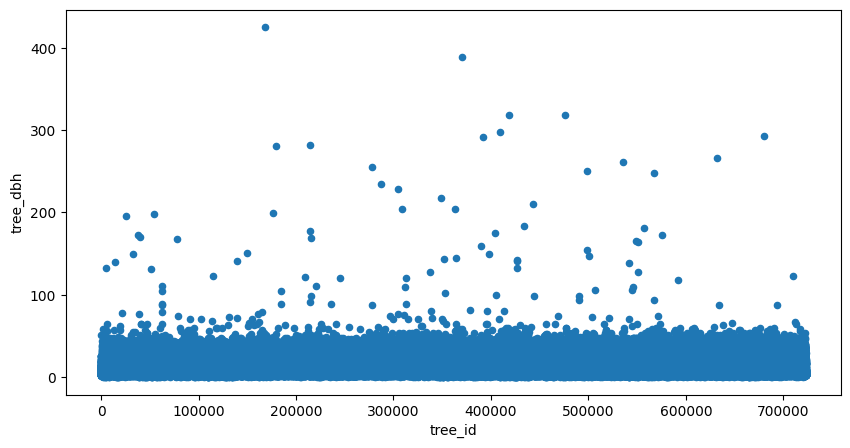

In [56]:
bt = alive[['tree_id', 'tree_dbh']].plot(kind='scatter', x= 'tree_id', y='tree_dbh', figsize=(10,5)) #visualize this big trees dist
plt.show()

In [57]:
# BIG TREES
len(alive[alive['tree_dbh'] > 100])


67

In [58]:
len(alive[alive['tree_dbh'] < 1]) # 222 data points, therefore it's better to replace those 0 cm dbh trees with the smaller percentile

222

##### Managing Outliers for dbh

In [59]:
alive.groupby('spc_latin')['tree_dbh'].describe()
#tree_dbh is a potential variable to determine the health of trees 

#Nevertheless, shows 0 dbh trees, this is whether a measure issue or they were registering seedlings smaller than dbh. Nothing in the documentation addresses this issue. 

,count,mean,std,min,25%,50%,75%,max
spc_latin,,,,,,,,
Acer,7080.0,11.675424,6.577626,0.0,7.0,11.0,15.0,59.0
Acer buergerianum,110.0,8.090909,4.544470,2.0,5.0,8.0,10.0,28.0
Acer campestre,2550.0,7.126275,4.437674,0.0,4.0,6.0,9.0,64.0
Acer ginnala,2049.0,7.869204,4.853365,0.0,4.0,7.0,10.0,40.0
Acer griseum,220.0,3.509091,3.578846,1.0,2.0,2.0,3.0,30.0
...,...,...,...,...,...,...,...,...
Tsuga canadensis,88.0,5.193182,3.959153,0.0,2.0,3.5,7.0,21.0
Ulmus americana,7975.0,11.953229,9.426278,0.0,4.0,9.0,17.0,65.0
Ulmus parvifolia,5345.0,7.417587,5.867390,0.0,3.0,5.0,10.0,118.0


In [60]:
stats = alive.groupby('spc_latin')['tree_dbh'].describe().reset_index()[['spc_latin', 'mean' ,'25%', '75%']] # get the percentiles by species
stats
alive = alive.merge(stats, on='spc_latin', how='left')

##### Managing Small trees (dbh== 0.0 inch)

In [61]:
# Asign 25%th values to 0 dbh trees

## before it's important to explicitly cast the type of 'tree_dbh' from int to float, to match the type of '25%' and avoid future compatibility issues in Pandas
alive['tree_dbh'] = alive['tree_dbh'].astype(float)

condition = alive['tree_dbh'] < alive['25%']
alive.loc[condition, 'tree_dbh'] = alive.loc[condition, '25%']

##### Managing big trees  (dbh== 60.0 inch)

In [62]:
# Asign 75%th value to > 100 dbh inch trees

condition2 = alive['tree_dbh'] >100
alive.loc[condition2, 'tree_dbh'] = alive.loc[condition2, '75%']
len(alive[alive['tree_dbh'] > 100])
alive['tree_dbh'].isna().sum()

np.int64(0)

##### Format DBH values from inches to centimeters

In [63]:
# Format dbh units, from inches to cm
alive[['dbh_cm']] = alive[['tree_dbh']]*2.54

# Check conversion
print(alive['dbh_cm'].describe())

count    652167.000000
mean         31.155431
std          20.575590
min           5.080000
25%          15.240000
50%          25.400000
75%          40.640000
max         254.000000
Name: dbh_cm, dtype: float64


##### Remove unused columns

In [64]:
#Clean columns
alive= alive.drop(['tree_dbh', 'mean', '25%', '75%'],axis=1)

#### Managing categorial variables after cleaning (performance improvement)

In [65]:
alive.dtypes

tree_id         int64
health         object
spc_latin      object
spc_common     object
curb_loc       object
steward        object
guards         object
sidewalk       object
root_stone     object
root_grate     object
root_other     object
trunk_wire     object
trnk_light     object
trnk_other     object
brch_light     object
brch_shoe      object
brch_other     object
borough        object
postcode        int64
latitude      float64
longitude     float64
dbh_cm        float64
dtype: object

In [66]:
from pandas.api.types import CategoricalDtype

def optimize_categorical_columns(df):
    """
    Convert categorical columns to 'category' type to optimize memory and performance.
    The columns 'health' and 'steward' are converted into sorted categories.
    """
    ordered_health = CategoricalDtype(categories=['Poor', 'Fair', 'Good'], ordered=True)
    ordered_steward = CategoricalDtype(categories=['None', '1or2', '3or4', '4orMore'], ordered=True)
    
    df['health'] = df['health'].astype(ordered_health)
    df['steward'] = df['steward'].astype(ordered_steward)
    
    categorical_columns = ['curb_loc', 'guards', 'sidewalk', 'root_stone', 'root_grate', 'root_other',
                           'trunk_wire', 'trnk_light', 'trnk_other', 'brch_light', 'brch_shoe',
                           'brch_other', 'borough']
    
    for col in categorical_columns:
        df[col] = df[col].astype('category')
    
    return df

df_trees = optimize_categorical_columns(alive)
df_trees.dtypes

tree_id          int64
health        category
spc_latin       object
spc_common      object
curb_loc      category
steward       category
guards        category
sidewalk      category
root_stone    category
root_grate    category
root_other    category
trunk_wire    category
trnk_light    category
trnk_other    category
brch_light    category
brch_shoe     category
brch_other    category
borough       category
postcode         int64
latitude       float64
longitude      float64
dbh_cm         float64
dtype: object

#### Visualizing Data

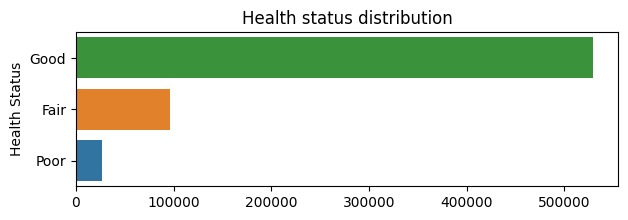

In [67]:
# Gráfico de barras de frecuencia
plt.figure(figsize=(7, 2))
sns.countplot(y=df_trees['health'], hue =df_trees['health'] ,order=df_trees['health'].value_counts().index) #for categorical variables
plt.title('Health status distribution')
plt.ylabel('Health Status')
plt.xlabel('')
plt.savefig('dbh.png', dpi=300, bbox_inches='tight')
plt.show()


In [68]:
class_counts = df_trees['health'].value_counts()
class_proportions = df_trees['health'].value_counts(normalize=True)
imbalance_ratio = class_counts.max() / class_counts.min()

print(f"Ratio de desbalance: {imbalance_ratio:.2f}")

Ratio de desbalance: 19.72


##### Imbalance Ratio: 19.72
This value indicates that the most frequent class (Good) appears 19.72 times more than your least frequent class (Poor).
Moderate to severe imbalance: since a ratio greater than 10:1 is generally considered a significant imbalance.

##### Practical interpretation: 
Implications for modeling: With this level of imbalance, it is expected that unadjusted models will have a strong tendency to predict the majority class, as indeed was observed.


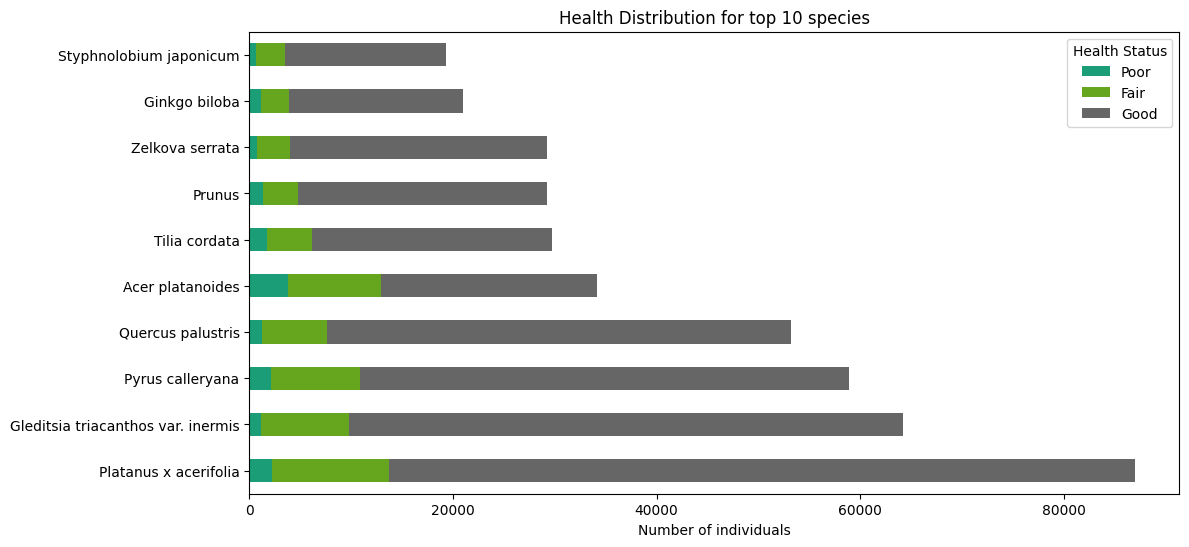

In [69]:
# Top 10 common species
top_species = df_trees['spc_latin'].value_counts().nlargest(10).index

# Sort top 10
filtered_data = df_trees[df_trees['spc_latin'].isin(top_species)]

# Crossed Table
health_counts = pd.crosstab(filtered_data['spc_latin'], filtered_data['health'])

# Sort again
health_counts = health_counts.loc[top_species]

health_counts.plot(kind='barh', stacked=True, figsize=(12, 6), colormap='Dark2')

plt.title('Health Distribution for top 10 species')
plt.xlabel('Number of individuals')
plt.ylabel('')
plt.legend(title='Health Status')
plt.savefig('species_health_dist.png', dpi=300, bbox_inches='tight')
plt.show()

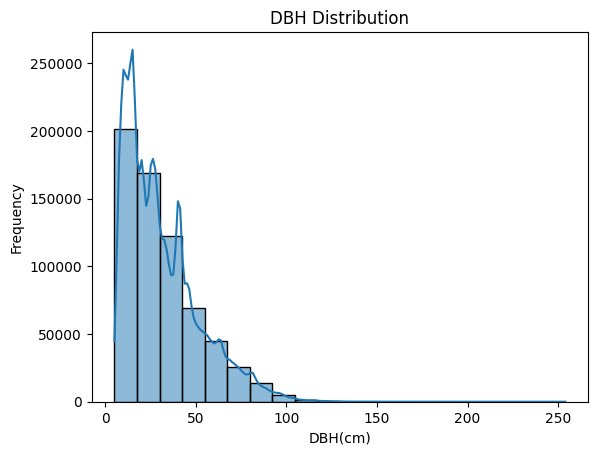

In [70]:
sns.histplot(df_trees['dbh_cm'], bins=20, kde=True)
plt.xlabel('DBH(cm)')
plt.ylabel('Frequency')
plt.title('DBH Distribution')
plt.savefig('dbh_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

#### Basic Diversity information

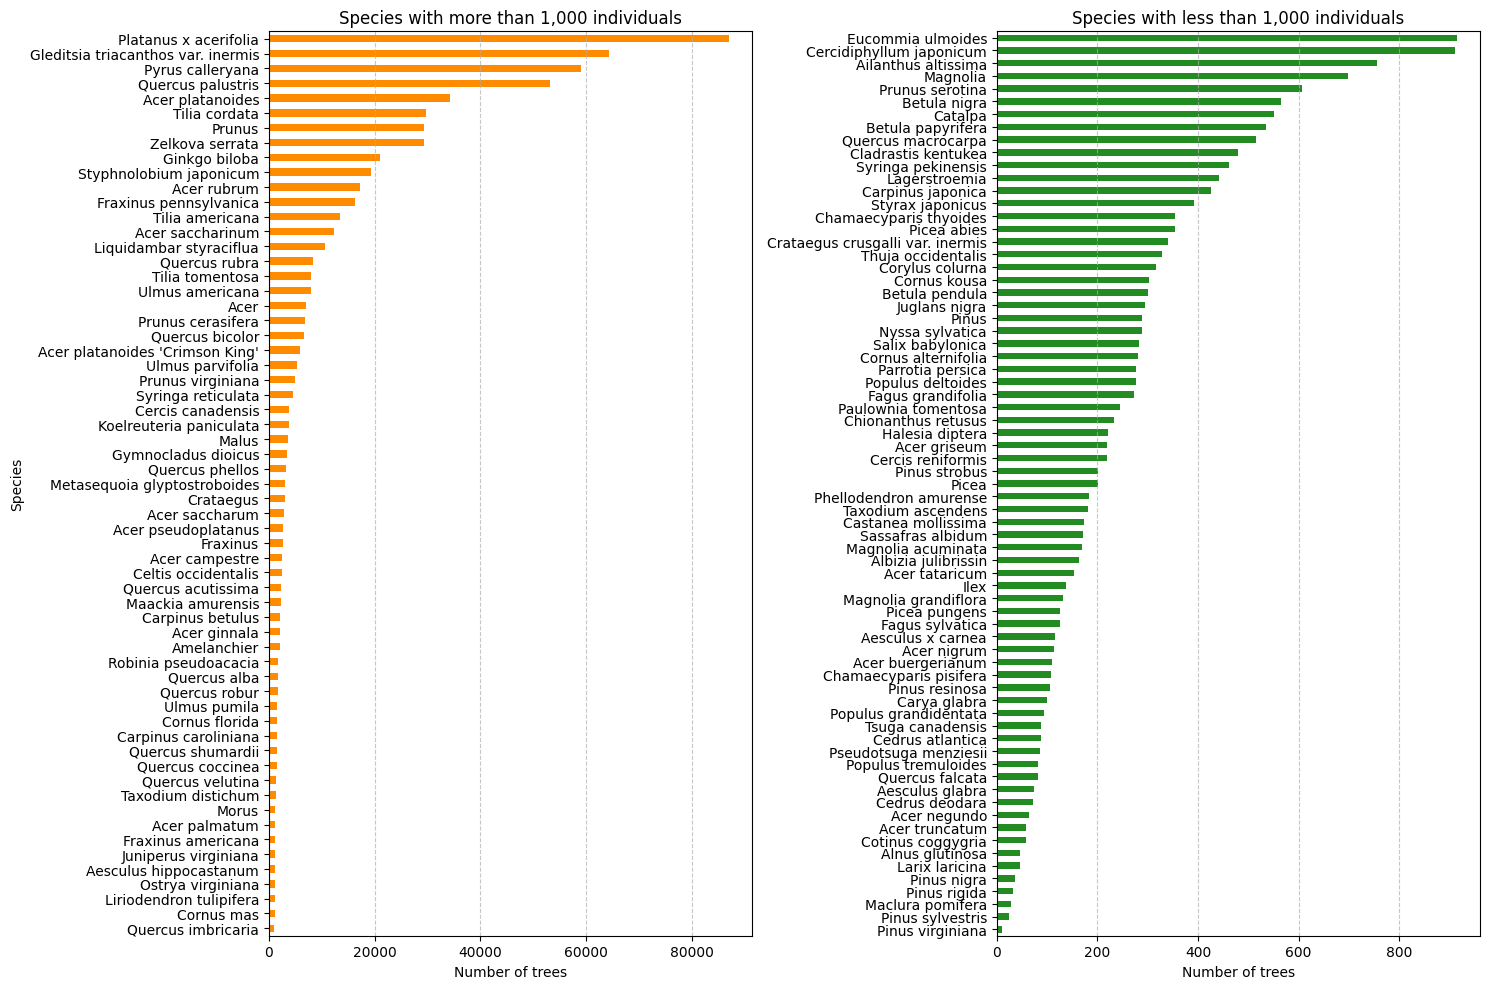

In [71]:
species_counts = df_trees['spc_latin'].value_counts()

# Create 2 groups
species_below_1000 = species_counts[species_counts < 1000]
species_above_1000 = species_counts[species_counts >= 1000]
with plt.rc_context({'figure.figsize': (10, 6), 'font.size': 10}):
    # Create 2 column chart
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10), sharex=False)
    
    # Species  >=1,000 individuals
    species_above_1000.sort_values().plot(kind='barh', color='darkorange', ax=axes[0])
    axes[0].set_title('Species with more than 1,000 individuals')
    axes[0].set_xlabel('Number of trees')
    axes[0].set_ylabel('Species') 
    axes[0].grid(axis='x', linestyle='--', alpha=0.7)
    
    # Species  < 1,000 individuals
    species_below_1000.sort_values().plot(kind='barh', color='forestgreen', ax=axes[1])
    axes[1].set_title('Species with less than 1,000 individuals')
    axes[1].set_xlabel('Number of trees')
    axes[1].grid(axis='x', linestyle='--', alpha=0.7)
    axes[1].set_ylabel('')
    plt.tight_layout()
    plt.show()


In [72]:
(df_trees['spc_latin'].value_counts() > 1000).sum()

np.int64(61)

In [73]:
(df_trees['spc_latin'].value_counts() < 200).sum()

np.int64(35)

In [74]:
(df_trees['spc_latin'].value_counts() < 50).sum()

np.int64(7)

##### Grouping in 'Other species' for Chi square
It was observed that there is a great inequality between the number of individuals of the different species, many having > 1000 individuals, reaching up to > 8000 individuals, and several species with less than 100 or 50 individuals . This could negatively affect the Chi-Square test, so I had to decide whether to eliminate the latter group or to group them under one name. 

I took the latter path, and grouped them under “Other species” so as not to lose their information, as this is a standard procedure in ecological studies, to preserve statistical robustness despite the possible diversity implications that this generalization entails.

###### Number of species affected = 19 (14,39%)
###### Individuals = 1174 (0.171%)

In [75]:
species_counts = df_trees['spc_latin'].value_counts()
rare_species = species_counts[species_counts < 100].index
df_clean = df_trees.copy() 
df_clean['spc_latin'] = df_clean['spc_latin'].replace(rare_species, 'Other species')

## Statistical Analysis

In [76]:
def descriptive_analysis(df):
    """Basic descriptive analysis for health status, number of species and top 10 species"""

    total_trees = len(df_clean)
    print(f'Total number of trees: {total_trees}')
    
    # Health status distribution
    health_counts = df_clean['health'].value_counts()
    print('\nHealth status distribution:')
    print(health_counts)
    print('\nPercentages:')
    print(health_counts / total_trees * 100)

    # Num of species
    n_species = df_clean['spc_common'].nunique()
    print(f"\nNum of species: {n_species}")
    
    # Top 10 common species
    top_species = df['spc_latin'].value_counts().head(10)
    print('\nTop 10 common species:')
    print(top_species)
    
    return 
descriptive_analysis(df_clean)

Total number of trees: 652167

Health status distribution:
health
Good    528845
Fair     96505
Poor     26817
Name: count, dtype: int64

Percentages:
health
Good    81.090426
Fair    14.797590
Poor     4.111984
Name: count, dtype: float64

Num of species: 132

Top 10 common species:
spc_latin
Platanus x acerifolia                 87014
Gleditsia triacanthos var. inermis    64262
Pyrus calleryana                      58931
Quercus palustris                     53185
Acer platanoides                      34189
Tilia cordata                         29742
Prunus                                29279
Zelkova serrata                       29258
Ginkgo biloba                         21024
Styphnolobium japonicum               19338
Name: count, dtype: int64


### Correlation analysis

#### Mutual information Analysis

      Variable  Mutual_Information  Porcentaje_MI
0    spc_latin            0.011517     100.000000
13  brch_other            0.008679      75.360709
10  trnk_other            0.007179      62.329106
15      dbh_cm            0.006711      58.270467
7   root_other            0.001324      11.499019
14     borough            0.001005       8.727953
5   root_stone            0.000452       3.928575
3       guards            0.000415       3.601460
8   trunk_wire            0.000359       3.118305
11  brch_light            0.000302       2.619739
6   root_grate            0.000240       2.085050
4     sidewalk            0.000211       1.830208
2      steward            0.000063       0.547868
9   trnk_light            0.000030       0.258997
12   brch_shoe            0.000026       0.223233
1     curb_loc            0.000017       0.147901


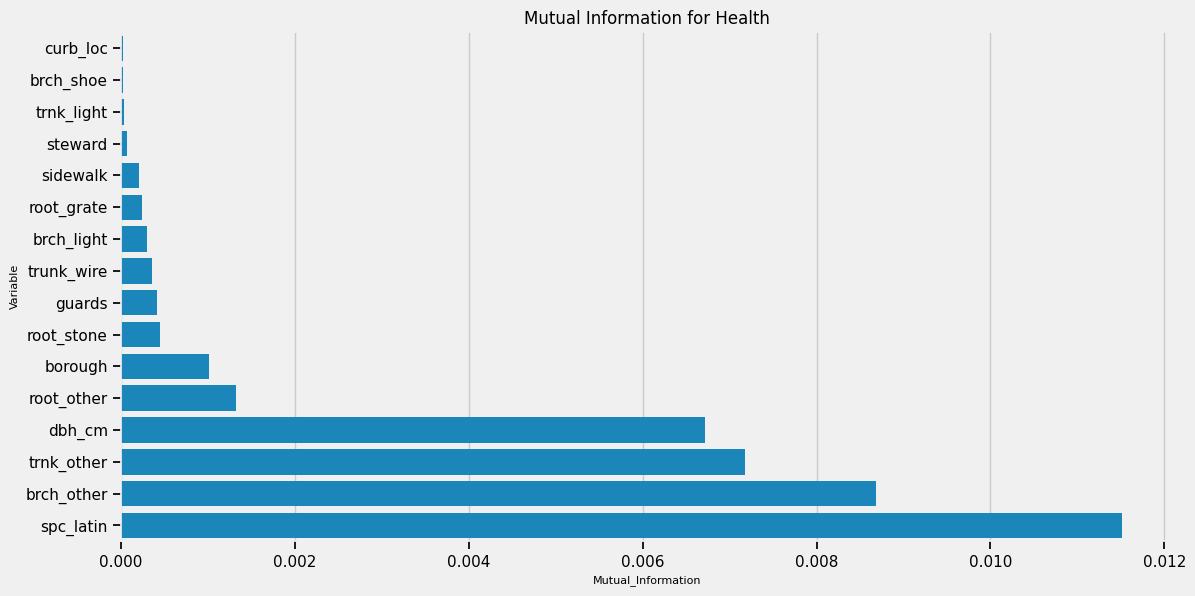

In [89]:
from sklearn.feature_selection import mutual_info_classif

# Prepare variables
X = df_trees[columns_to_count + ['dbh_cm']]
# For categorical variables, code
X_encoded = X.copy()
for col in columns_to_count:
    X_encoded[col] = X_encoded[col].astype('category').cat.codes
y = df_trees['health'].astype('category').cat.codes

# Array to indicate which are discrete
is_discrete = [True] * len(columns_to_count) + [False]  # False para dbh_cm

# Calculta Mutual Information
mi_scores = mutual_info_classif(X_encoded, y, discrete_features=is_discrete)

# Result to DF
mi_results = pd.DataFrame({
    'Variable': columns_to_count + ['dbh_cm'],
    'Mutual_Information': mi_scores
})
mi_results = mi_results.sort_values('Mutual_Information', ascending=False)
mi_results['Porcentaje_MI'] = mi_results['Mutual_Information'] / mi_results['Mutual_Information'].max() * 100
print(mi_results)

#plot results
plt.figure(figsize=(12, 6))
sns.barplot(x='Mutual_Information', y='Variable', data=mi_results.sort_values('Mutual_Information'))
plt.title('Mutual Information for Health')
plt.tight_layout()
plt.show()


##### Mutual

Measures the statistical dependence between categorical variables and tree health. This analysis complements the previous Cramer's V analysis.

Mutual Information quantifies how much information one variable provides about another. In this case, it measures how much each variable helps us predict the health status of the trees. Higher values indicate greater predictive power.

##### Variables with the highest predictive power:

1. spc_latin (tree species) shows the highest mutual information with health (value 0.0115, 100%).
2. brch_other (other branch problems) has the second highest value (0.0087, 75.4%).
3. dbh_cm (tree diameter) appears as the third most important variable (0.0076, 65.9%).
4. trnk_other (other trunk problems) is the fourth (0.0072, 62.3%).

#### Cramer's V
Cramer's V coefficient could properly complement the analysis by providing a standardized measure of the GLOBAL STRENGTH of the association between variables.

In [78]:
columns_to_count = ['spc_latin','curb_loc', 'steward', 'guards', 'sidewalk', 'root_stone',
                    'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other',
                    'brch_light', 'brch_shoe', 'brch_other', 'borough']
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1), (rcorr-1)))

# Calculate Cramer's V for each variable with health
results = {}
for col in columns_to_count:
    results[col] = cramers_v(df_trees[col], df_trees['health'])

# Sort results by strength of association
results_sorted = {k: v for k, v in sorted(results.items(), key=lambda item: item[1], reverse=True)}
df_cramer = pd.DataFrame([results_sorted])
df_cramer = pd.DataFrame(list(results_sorted.items()), columns=['Variable', 'Cramers_V'])

df_cramer['Percentage'] = df_cramer['Cramers_V'].apply(lambda x: f"{x*100:.2f}%")


df_cramer

,Variable,Cramers_V,Percentage
0,brch_other,0.152374,15.24%
1,trnk_other,0.134535,13.45%
2,spc_latin,0.112692,11.27%
3,root_other,0.054359,5.44%
4,borough,0.032531,3.25%
5,root_stone,0.030345,3.03%
6,trunk_wire,0.027935,2.79%
7,brch_light,0.025012,2.50%
8,root_grate,0.023368,2.34%
9,guards,0.020890,2.09%


#### ANOVA to analyze Diameter and Health correlation

In [79]:
# ANOVA
from scipy.stats import f_oneway

# Groups separated by health
groups = [df_trees[df_trees['health'] == health]['dbh_cm']
          for health in df_trees['health'].unique()]
          
f_stat, p_value = f_oneway(*groups)
print(f"ANOVA: F={f_stat:.2f}, p={p_value:.5f}")

# Eta squared (equivalent of R² for categorical vs. continuous variable)

# sum of squares total and between groups
ss_total = np.sum((df_trees['dbh_cm'] - df_trees['dbh_cm'].mean())**2)
health_means = df_trees.groupby('health', observed=True)['dbh_cm'].mean()
ss_between = np.sum([(health_means[h] - df_trees['dbh_cm'].mean())**2 * (df_trees['health'] == h).sum() 
                     for h in df_trees['health'].unique()])
eta_squared = ss_between / ss_total

print(f"Eta cuadrado: {eta_squared:.4f} ({eta_squared*100:.2f}%)")

ANOVA: F=1520.11, p=0.00000
Eta cuadrado: 0.0046 (0.46%)


The ANOVA test confirms that there are statistically significant differences in mean diameter between trees with different health status.
The high F-value (1520.11) indicates that the differences between groups are much larger than the differences within groups.

##### However, only 0.46% of the variation in tree health can be explained by tree diameter. is very weak in practical terms.

With such a large data set (680,000 records), even very small relationships can be statistically significant. ANOVA detects that the relationship exists, but eta squared shows that it is weak.

In [80]:
#Drillthrough
print(df_trees.groupby('health', observed=True)['dbh_cm'].describe())

           count       mean        std   min    25%    50%    75%     max
health                                                                   
Poor     26817.0  25.396022  16.712463  5.08  12.70  20.32  35.56  251.46
Fair     96505.0  29.642528  18.571990  5.08  15.24  25.40  40.64  203.20
Good    528845.0  31.723561  21.036904  5.08  15.24  25.40  43.18  254.00


##### There is a trend where trees with larger diameter tend to have better health. Average diameter increases consistently from “Poor” to “Good”.

##### The standard deviation is high in all categories (between 16.7 and 21.0 cm), indicating a large overlap between groups. This explains the low eta squared value (0.46%).


#### Visualize DBH and health

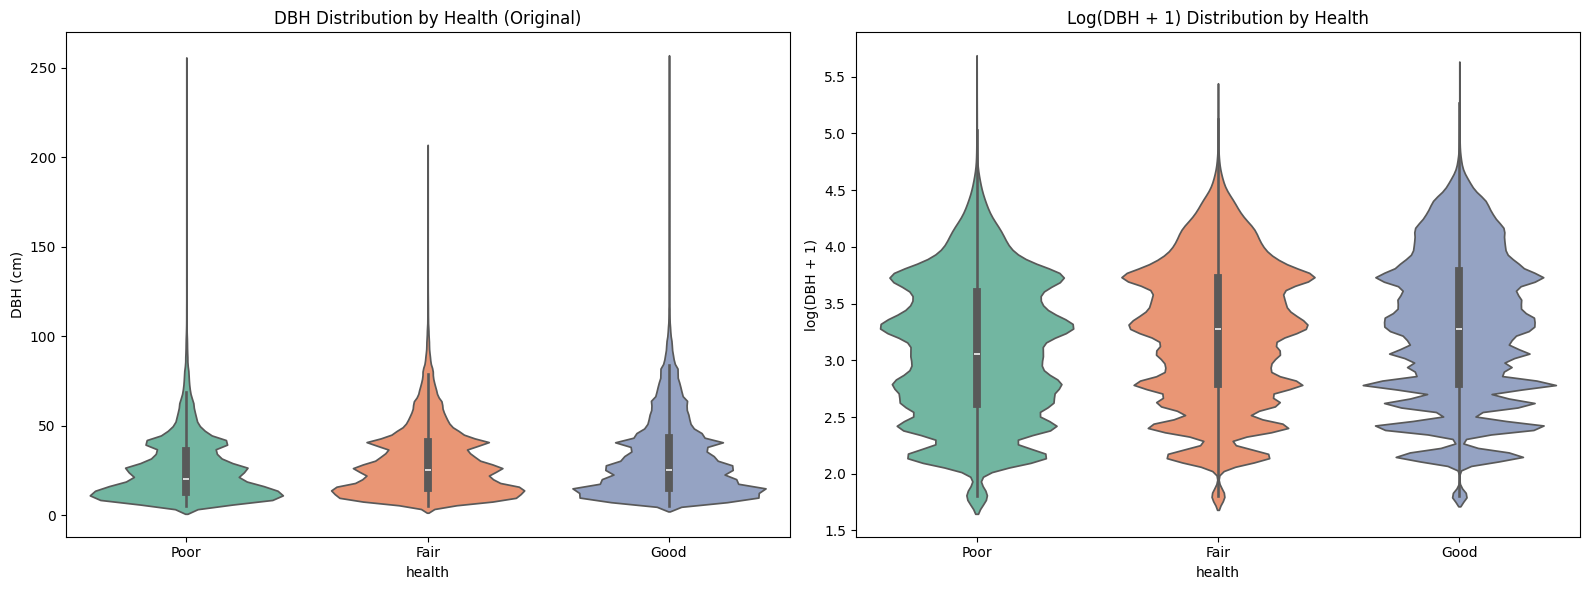

In [81]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1st - Violinplot DBH normal
sns.violinplot(
    ax=axes[0],
    x='health',
    y='dbh_cm',
    data=df_trees,
    order=['Poor', 'Fair', 'Good'],
    palette='Set2',
    hue='health',
    legend= False
)
axes[0].set_title('DBH Distribution by Health (Original)')
axes[0].set_ylabel('DBH (cm)')

# 2nd - Violinplot log(DBH + 1)
sns.violinplot(
    ax=axes[1],
    x='health',
    y=np.log1p(df_trees['dbh_cm']),
    data=df_trees,
    order=['Poor', 'Fair', 'Good'],
    palette='Set2',
    hue='health',
    legend= False
)
axes[1].set_title('Log(DBH + 1) Distribution by Health')
axes[1].set_ylabel('log(DBH + 1)')

plt.tight_layout()
plt.savefig('dbh_distribution_by_health.png', dpi=300, bbox_inches='tight')
plt.show()


### DBH Statistical summary:

- Mutual Information analysis shows dbh_cm has high importance (65.9% relative to the most important variable)
- ANOVA test shows a highly significant relationship (F=1520.11, p<0.00001)
- Eta squared shows a very small effect size (0.46%)
- Descriptive statistics show a clear pattern where healthier trees tend to have larger diameters

#### This shows that different statistical measures capture different aspects of a relationship:

##### 1. Statistical significance vs. practical significance:

The ANOVA p-value shows the relationship is not due to chance
The tiny eta squared reveals the effect size is small in terms of explained variance


##### 2. Linear vs. non-linear relationships:

Eta squared primarily captures linear relationships (variance explained)
Mutual information captures any kind of statistical dependency, including non-linear relationships


##### 3. Large sample size effect:

With 680,000 trees, even tiny effects become statistically significant
The F-statistic is large due to the enormous sample size, not necessarily the strength of the relationship


#### Final insight:


##### ANOVA and the mutual information score suggests dbh_cm might be more useful when considered in combination with other variables or in non-linear models, rather than as a standalone linear predictor.

#### These results show that the following are the most relevant variables correlated with tree health and therefore the ones that should be studied further to predict tree health.:
1. brch_other: Problems in the branches not related to wires, light
2. trnk_other: Presence of other trunk problems
3. dbh_cm : Diamter at breast height
4. spc_latin: Species name

#### Chi-squared and Pearson's standardized residuals for relavant variables

In [82]:
#Inderencial Stastistic Visualizations config
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 8
plt.rcParams['axes.labelsize'] = 8


--------------------------------------------------
Variable: brch_other
Chi-cuadrado: 15143.89, p-value: 0.00000

Standardized residuals:
health           Poor       Fair       Good
brch_other                                 
No         -16.533837 -14.055423   9.727377
Yes         83.944913  71.361612 -49.387437


<Figure size 700x500 with 0 Axes>

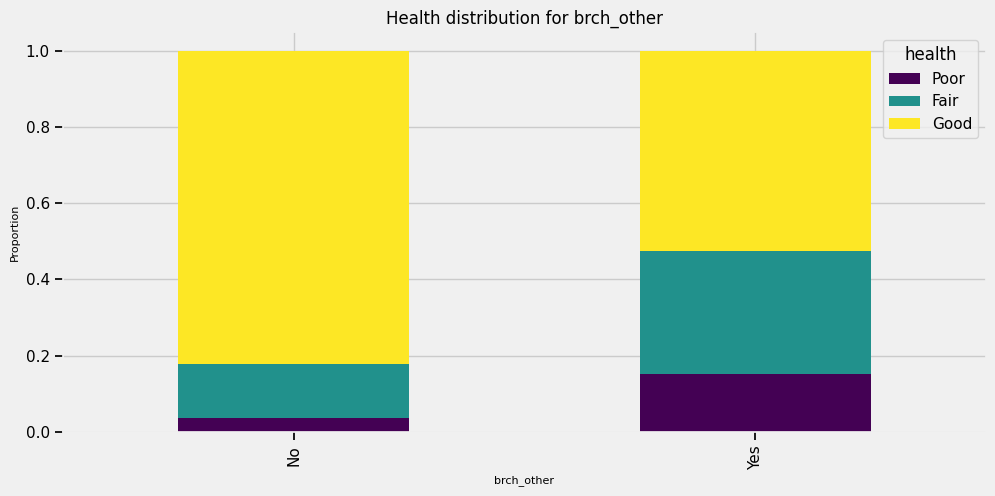


--------------------------------------------------
Variable: trnk_other
Chi-cuadrado: 11806.03, p-value: 0.00000

Standardized residuals:
health           Poor       Fair       Good
trnk_other                                 
No         -16.167468 -15.059617  10.073847
Yes         70.512600  65.680833 -43.935957


<Figure size 700x500 with 0 Axes>

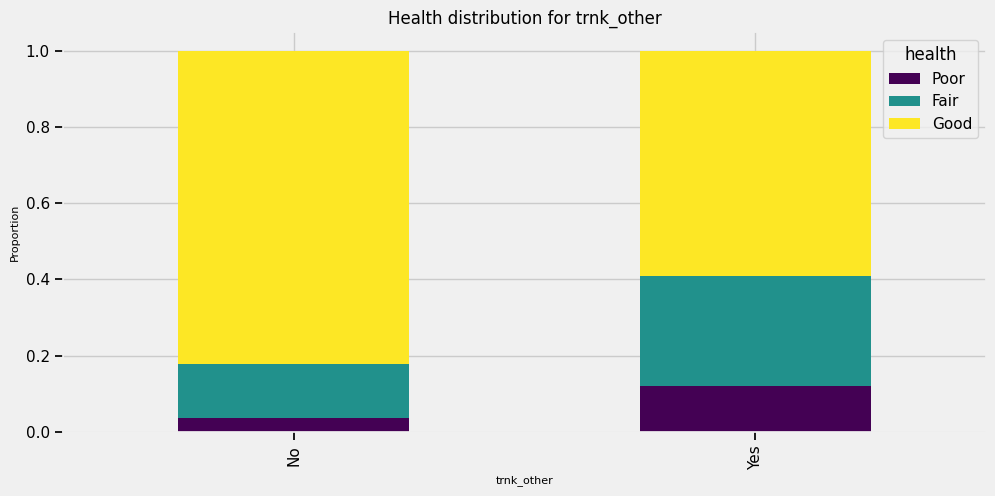


--------------------------------------------------
Variable: spc_latin
Chi-cuadrado: 16826.20, p-value: 0.00000

Standardized residuals (Top 20 species):
health                                   Poor       Fair       Good
spc_latin                                                          
Platanus x acerifolia              -23.070620 -12.082019  10.356369
Gleditsia triacanthos var. inermis -28.255062  -9.611084  10.468298
Pyrus calleryana                    -6.789719   0.520782   1.306480
Quercus palustris                  -20.356248 -16.638923  11.691749
Acer platanoides                    63.293196  57.682907 -38.893698
Tilia cordata                       14.212082   0.586377  -3.450847
Prunus                               2.912343 -13.438991   5.085047
Zelkova serrata                    -12.140062 -17.302433  10.125019
Ginkgo biloba                        8.621617  -5.935186   0.593926
Styphnolobium japonicum             -6.353995   0.531691   1.203702
Acer rubrum                  

<Figure size 1000x1000 with 0 Axes>

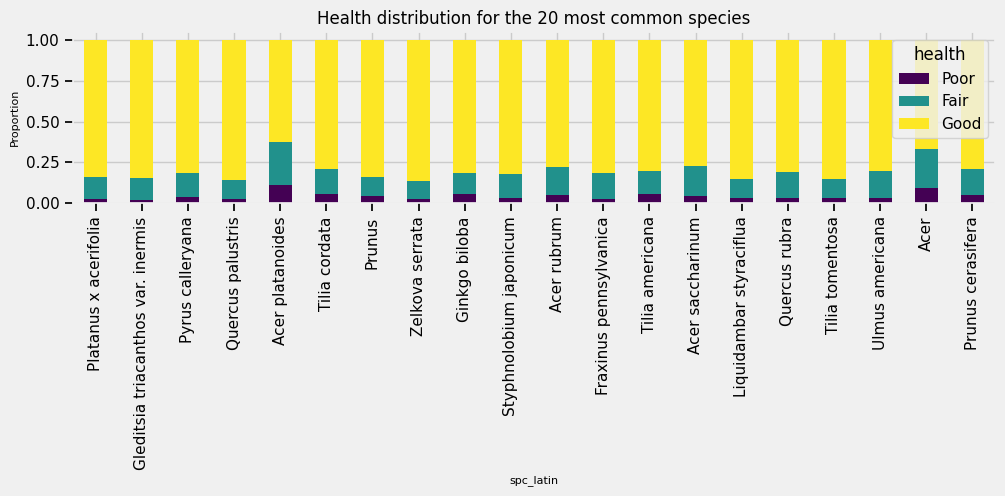

In [83]:
for var in ['brch_other', 'trnk_other', 'spc_latin']:
    # Cross table for all the categories
    cont_table_full = pd.crosstab(df_trees[var], df_trees['health'])
    
    # Chi-squared and pvalue
    chi2, p, dof, expected = chi2_contingency(cont_table_full)
    
    print(f"\n{'-'*50}")
    print(f"Variable: {var}")
    print(f"Chi-cuadrado: {chi2:.2f}, p-value: {p:.5f}")
    
    # Pearson's standardized residuals with all the categories
    residuals = (cont_table_full - expected) / np.sqrt(expected)
    

    if var == 'spc_latin':
        top_species = df_trees[var].value_counts().nlargest(20).index
        print("\nStandardized residuals (Top 20 species):")
        print(residuals.loc[top_species])
    else:
        print("\nStandardized residuals:")
        print(residuals)
    
    if var == 'spc_latin':
        top_species = df_trees[var].value_counts().nlargest(20).index.tolist()
        #sort top 20 species
        cont_table_viz = cont_table_full.loc[top_species]
        
        prop_table = cont_table_viz.div(cont_table_viz.sum(axis=1), axis=0)
        plt.figure(figsize=(10, 10))
        prop_table.plot(kind='bar', stacked=True, colormap ='viridis')
        plt.title(f'Health distribution for the 20 most common species')
        plt.xticks(rotation=90)
    else:
        prop_table = cont_table_full.div(cont_table_full.sum(axis=1), axis=0)
        plt.figure(figsize=(7, 5))
        prop_table.plot(kind='bar', stacked=True, colormap ='viridis')
        plt.title(f'Health distribution for {var}')
    
    plt.ylabel('Proportion')
    plt.tight_layout()
    plt.show()

#### Visualizations for Residuals for species

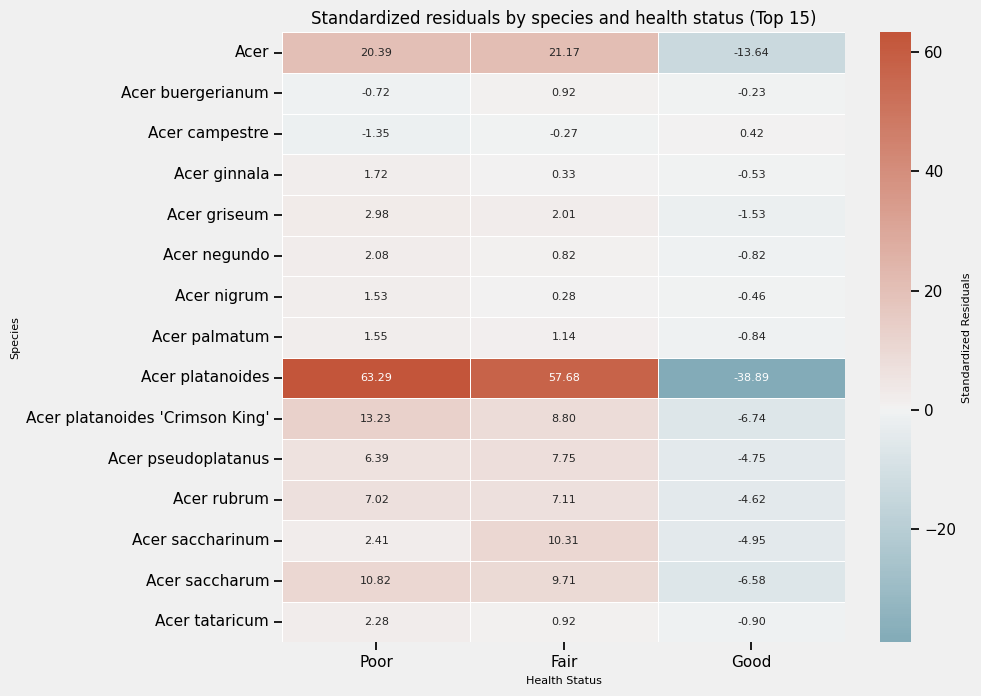

In [84]:
from matplotlib.ticker import PercentFormatter
import seaborn as sns

def view_results(contingency_table, residuals, var_name):
    """Generate visualizations to interpret results"""
    
    if var_name == 'spc_latin':  # Solo aplicar a spc_latin               
        #  Standardized Residuals heat map
        def plot_residuals_heatmap():
            # Select 15 species only
            top_species = residuals.index.tolist()[:15]  # Top 15 species
            residuals_top = residuals.loc[top_species]
            
            cmap = sns.diverging_palette(220, 20, as_cmap=True)
            
            fig, ax = plt.subplots(figsize=(10, 7))
            
            # Create heatmap
            sns.heatmap(residuals_top, cmap=cmap, center=0, 
                      annot=True, fmt=".2f", linewidths=.5, ax=ax,
                      cbar_kws={'label': 'Standardized Residuals'})
            
            ax.set_title('Standardized residuals by species and health status (Top 15)')
            ax.set_xlabel('Health Status')
            ax.set_ylabel('Species')
            
            plt.tight_layout()
            plt.savefig('species_residuals_heatmap.png', dpi=300, bbox_inches='tight')
            plt.show()
        
        # run visualizations
        plot_residuals_heatmap()
view_results(cont_table_full, residuals, var)

#### General patterns:

##### Species with better than average health (positive residuals in “Good” and negative in “Poor”):

1. Platanus x acerifolia
2. Gleditsia triacanthos var. inermis
3. Quercus palustris
4. Zelkova serrata


##### Species with worse health than average (negative residuals in “Good” and positive in “Poor”):

1. Acer platanoides (the most extreme case).
2. Tilia cordata (although not in “Fair”)


##### Species with mixed or less marked patterns:

1. Prunus
2. Ginkgo biloba
3. Tilia americana



##### Remarks for forest management:
1. Acer platanoides shows very significant health problems, which could indicate:

High susceptibility to pests or diseases.
Poor adaptation to urban conditions of NY
Possible need to reconsider its use in new plantings.


2. Platanus x acerifolia, Gleditsia triacanthos and Quercus palustris could be preferred candidates for future plantings due to their better health status.
It would be useful to investigate the specific characteristics that make some species perform better, such as:

Tolerance to contamination
Resistance to common diseases
Adaptation to urban conditions


#### Visualize with Qgis

In [85]:
# Geo info Latitude and Longitude uses the coordinate system GCS_WGS_1984. 
df_trees.to_csv('df_trees.csv',index=False)   


### Identify Significant Associations

#### Visualize most resistent species and less resistent species


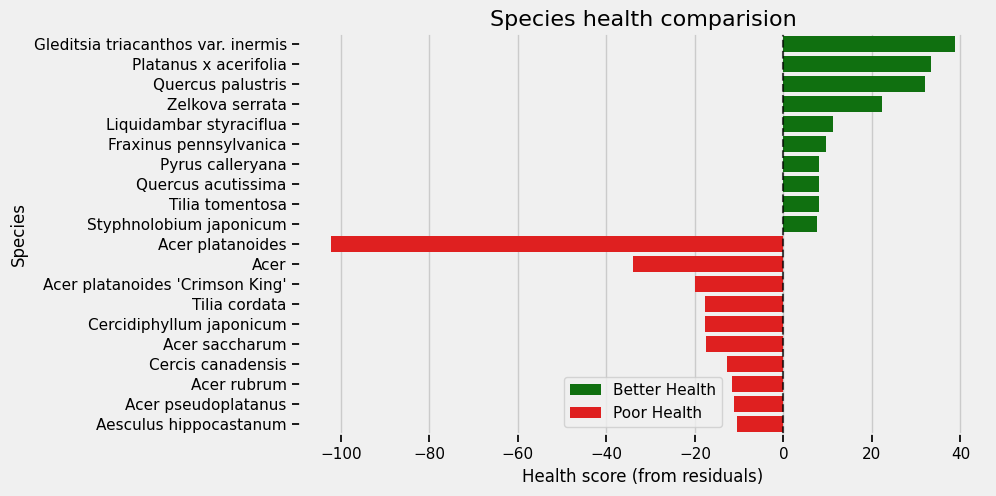

In [86]:
# 1. Create a health metric by species using standardized residues 

# DF with residuals, species and health status
species_health = pd.DataFrame(residuals.stack()).reset_index()
species_health.columns = ['spc_latin', 'health', 'residual']

# Calculate ponderated health 
def health_score(group):
    score = 0
    # Weights for each category
    weights = {'Good': 1.0, 'Fair': 0.0, 'Poor': -1.0}
    
    for _, row in group.iterrows():
        # Multiply residual by corresponding weight
        score += row['residual'] * weights[row['health']]
    
    return score

# Group by species and calculate score 

spc_scores = species_health.groupby('spc_latin').apply(health_score, include_groups=False)
spc_scores = spc_scores.reset_index()
spc_scores.columns = ['spc_latin', 'score_health']

# 2. Identify 10 species with best health and worst health
best_spc = spc_scores.sort_values('score_health', ascending=False).head(10)
poor_spc = spc_scores.sort_values('score_health', ascending=True).head(10)


# Merge two types into a single DF 
top_especies = pd.concat([
    best_spc.assign(category="Better Health"),
    poor_spc.assign(category="Poor Health")
])

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='score_health', y='spc_latin', hue='category', 
                data=top_especies, palette={'Better Health': 'green', 'Poor Health': 'red'})
plt.title('Species health comparision', fontsize=16)
plt.xlabel('Health score (from residuals)', fontsize=12)
plt.ylabel('Species', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(title="", loc = 8 )
plt.savefig('species_health_comparision.png', dpi=300, bbox_inches='tight')
plt.show()

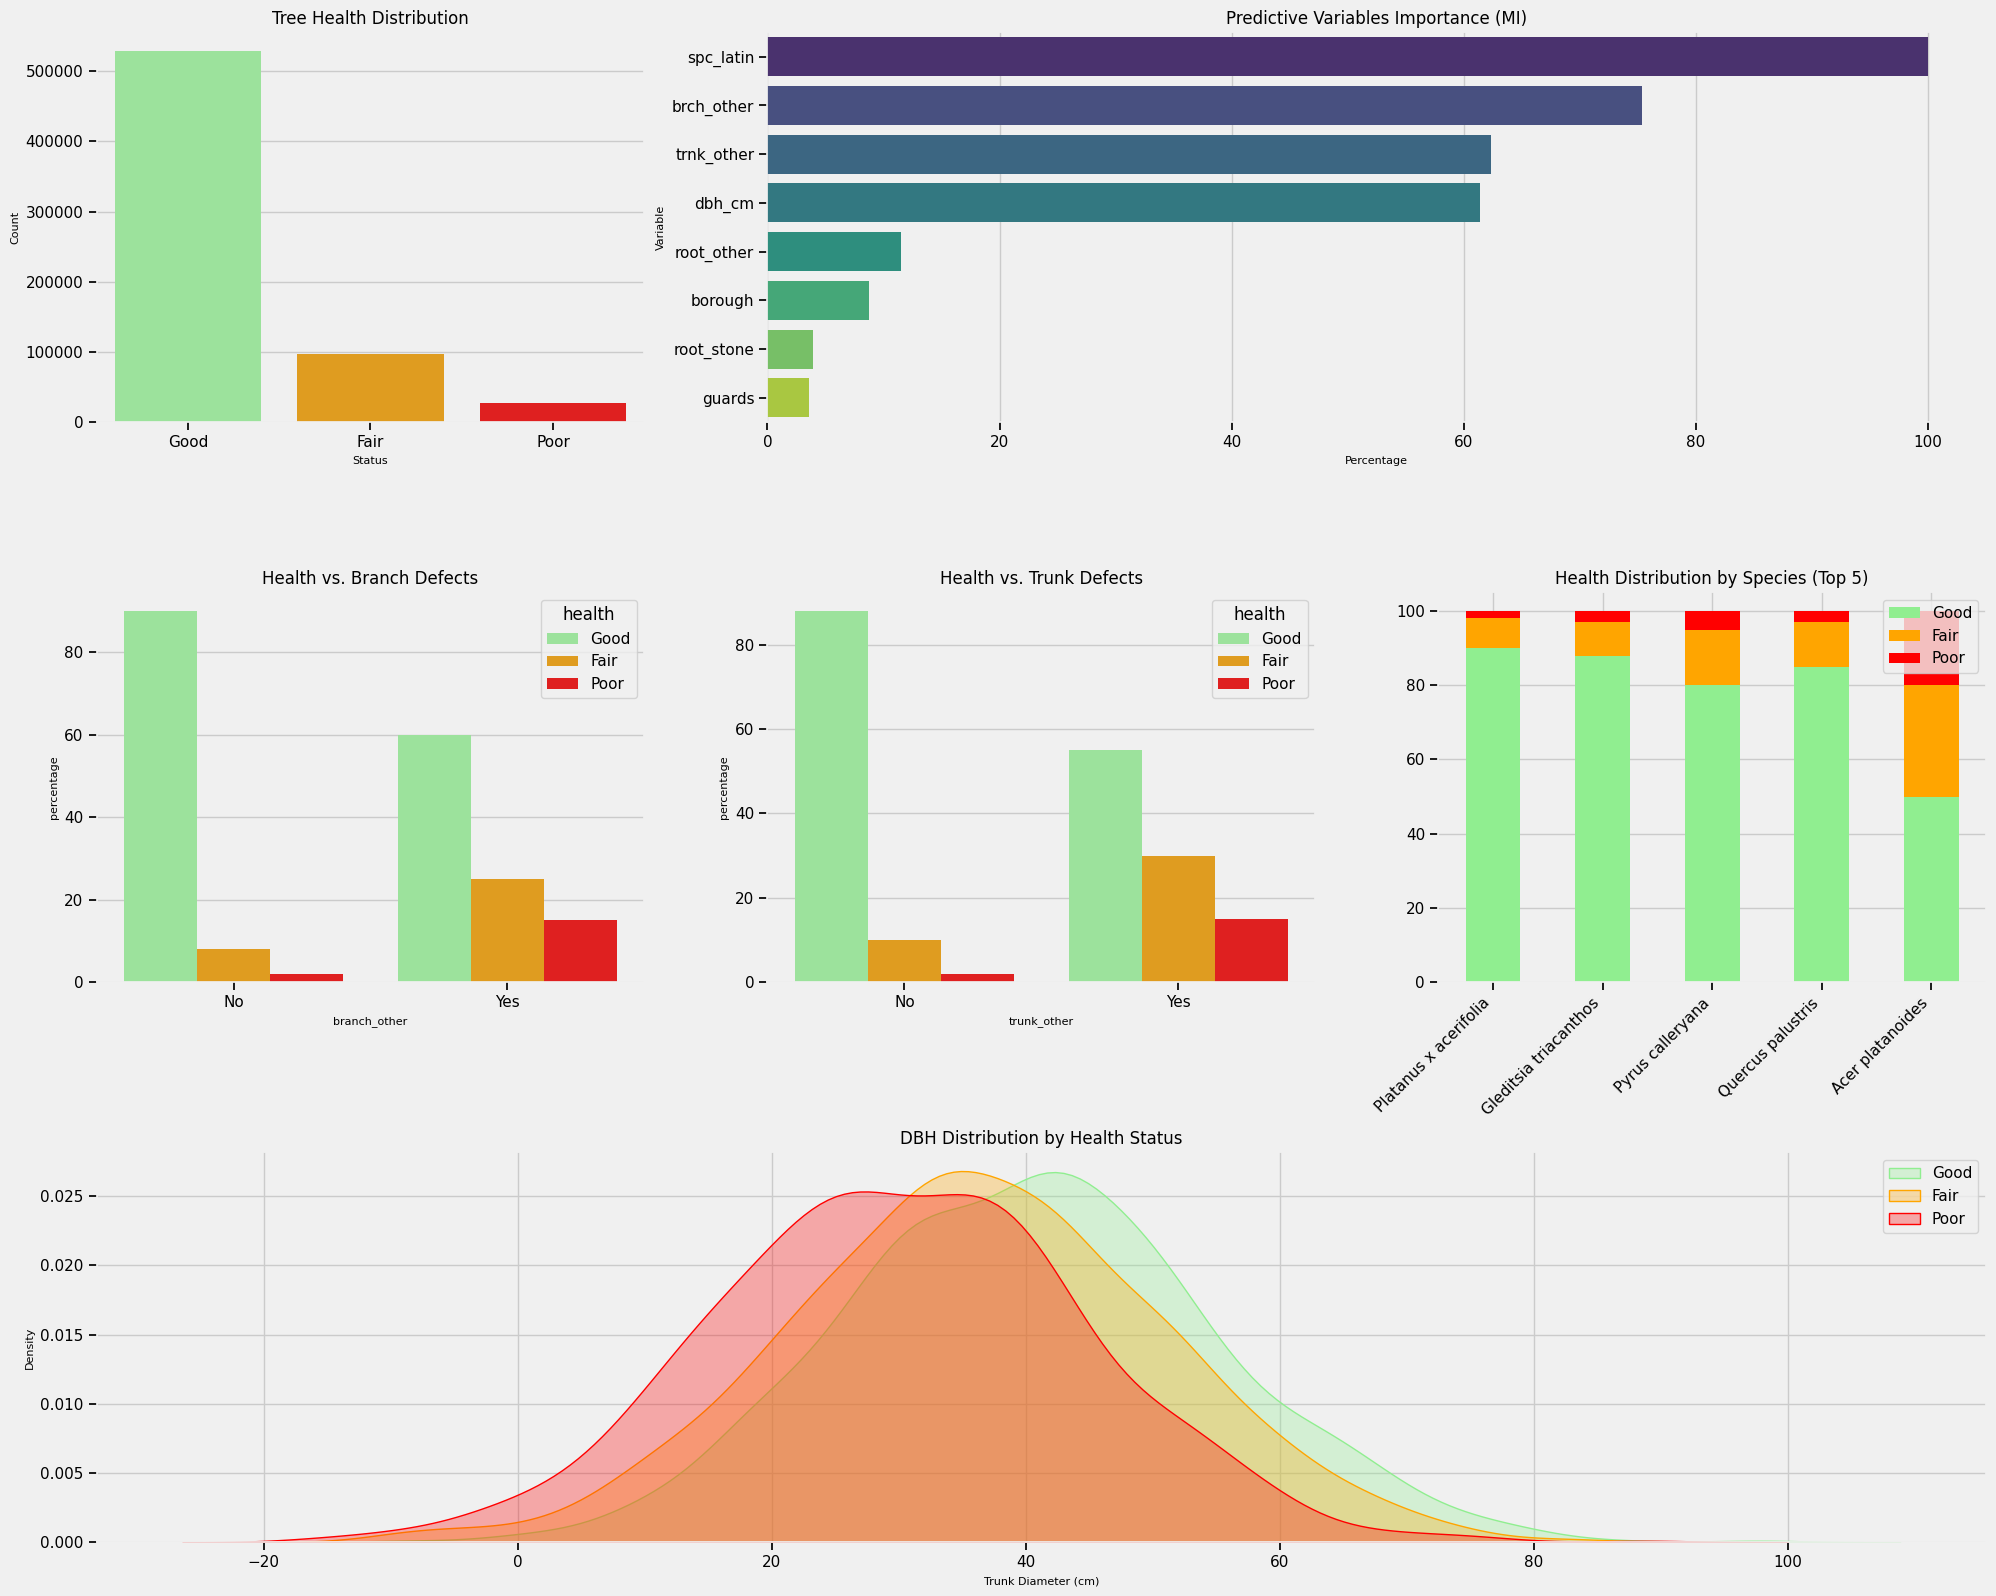

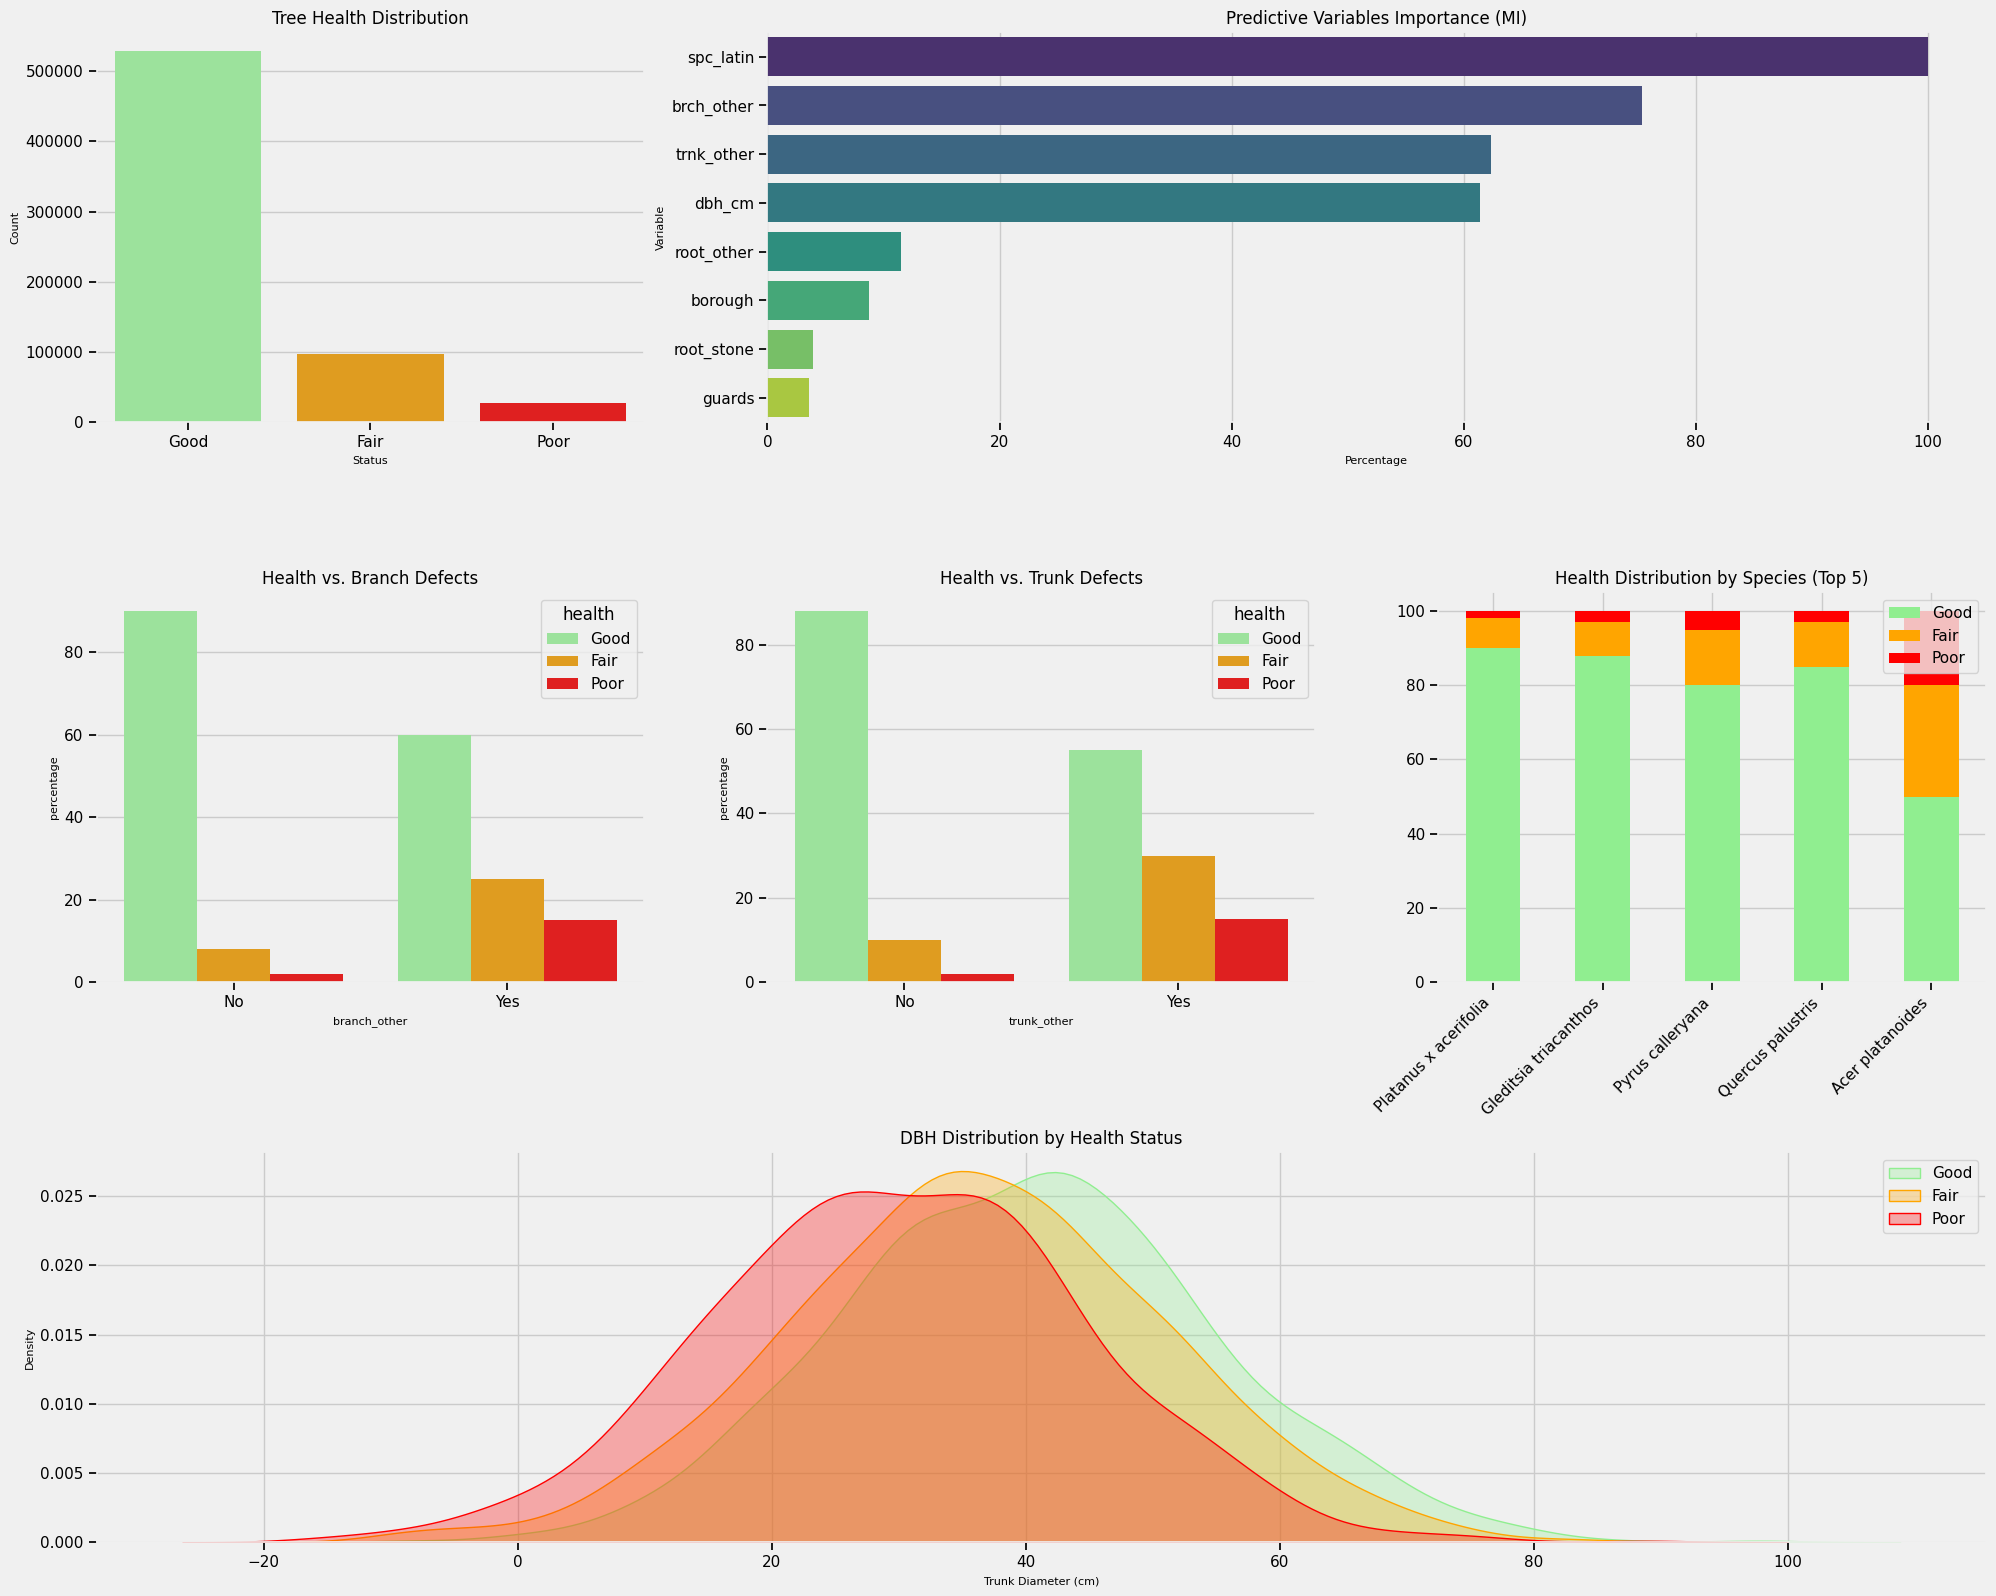

In [91]:
def create_eda_dashboard(df):
    from matplotlib.gridspec import GridSpec
    
    fig = plt.figure(figsize=(20, 16))
    gs = GridSpec(3, 3, figure=fig)
    
    # Health distribution
    ax1 = fig.add_subplot(gs[0, 0])
    health_counts = pd.DataFrame({
        'Status': ['Good', 'Fair', 'Poor'],
        'Count': [528845, 96505, 26817],
        'Percentage': [81.09, 14.80, 4.11]
    })
    sns.barplot(x='Status', y='Count', data=health_counts, hue='Status', palette={
        'Good': 'lightgreen', 'Fair': 'orange', 'Poor': 'red'
    }, ax=ax1)
    ax1.set_title('Tree Health Distribution')
    
    # Variable importance
    ax2 = fig.add_subplot(gs[0, 1:])
    sns.barplot(x='Percentage', y='Variable', hue='Variable', data=mi_df.head(8), 
                legend=False, palette='viridis', ax=ax2)
    ax2.set_title('Predictive Variables Importance (MI)')
    
    # Branch defects vs health relationship
    ax3 = fig.add_subplot(gs[1, 0])
    # Example data
    brch_health = pd.DataFrame({
        'branch_other': ['No', 'No', 'No', 'Yes', 'Yes', 'Yes'],
        'health': ['Good', 'Fair', 'Poor', 'Good', 'Fair', 'Poor'],
        'percentage': [90, 8, 2, 60, 25, 15]
    })
    sns.barplot(x='branch_other', y='percentage', hue='health', data=brch_health, 
                palette={'Good': 'lightgreen', 'Fair': 'orange', 'Poor': 'red'}, ax=ax3)
    ax3.set_title('Health vs. Branch Defects')
    
    # Trunk defects vs health relationship
    ax4 = fig.add_subplot(gs[1, 1])
    # Example data
    trnk_health = pd.DataFrame({
        'trunk_other': ['No', 'No', 'No', 'Yes', 'Yes', 'Yes'],
        'health': ['Good', 'Fair', 'Poor', 'Good', 'Fair', 'Poor'],
        'percentage': [88, 10, 2, 55, 30, 15]
    })
    sns.barplot(x='trunk_other', y='percentage', hue='health', data=trnk_health, 
                palette={'Good': 'lightgreen', 'Fair': 'orange', 'Poor': 'red'}, ax=ax4)
    ax4.set_title('Health vs. Trunk Defects')
    
    # Top 5 species and their health
    ax5 = fig.add_subplot(gs[1, 2])
    # Example data
    species_health = pd.DataFrame({
        'spc_latin': ['Platanus x acerifolia', 'Gleditsia triacanthos', 'Pyrus calleryana', 
                     'Quercus palustris', 'Acer platanoides'],
        'Good': [90, 88, 80, 85, 50],
        'Fair': [8, 9, 15, 12, 30],
        'Poor': [2, 3, 5, 3, 20]
    })
    species_health.set_index('spc_latin').plot(kind='bar', stacked=True, ax=ax5,
                                             color=['lightgreen', 'orange', 'red'])
    ax5.set_title('Health Distribution by Species (Top 5)')
    ax5.set_xlabel('')
    ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45, ha='right')
    
    # DBH vs Health
    ax6 = fig.add_subplot(gs[2, 0:])
    # Simulating data for example
    import numpy as np
    np.random.seed(42)
    dbh_good = np.random.normal(40, 15, 1000)
    dbh_fair = np.random.normal(35, 15, 1000)
    dbh_poor = np.random.normal(30, 15, 1000)
    
    sns.kdeplot(dbh_good, ax=ax6, color='lightgreen', label='Good', fill=True, alpha=0.3)
    sns.kdeplot(dbh_fair, ax=ax6, color='orange', label='Fair', fill=True, alpha=0.3)
    sns.kdeplot(dbh_poor, ax=ax6, color='red', label='Poor', fill=True, alpha=0.3)
    ax6.set_title('DBH Distribution by Health Status')
    ax6.set_xlabel('Trunk Diameter (cm)')
    ax6.legend()
    plt.tight_layout()
    plt.savefig('dashboard.png', dpi=300, bbox_inches='tight')
    return fig
create_eda_dashboard(df_trees)